In [1]:
!pip install -q catboost




[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor

In [3]:
validate = pd.read_parquet("/Users/samsanovicekaterina/dl.25/parquet_files/validate_agg_f.parquet")
user_agg = pd.read_parquet("/Users/samsanovicekaterina/dl.25/parquet_files/user_aggregates.parquet")
publisher_agg = pd.read_parquet("/Users/samsanovicekaterina/dl.25/parquet_files/publisher_aggregates.parquet")
history = pd.read_csv("/Users/samsanovicekaterina/dl.25/data/history.tsv", sep="\t")
answers = pd.read_csv("/Users/samsanovicekaterina/dl.25/data/validate_answers.tsv", sep ='\t')
validate_begin = pd.read_csv("/Users/samsanovicekaterina/dl.25/data/validate.tsv", sep ='\t')

In [4]:
validate

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,cluster_0,cluster_1,cluster_2,hour_start_of_day,...,pub_mean_hour_of_day,pub_mean_imp_per_user,pub_premium_ratio,pub_high_volume_ratio,cpm_x_duration,cpm_x_audience,cpm_per_hour,cpm_deviation,aud_pub_quality,campaign_intensity
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",0.680483,0.101784,0.158447,2,...,13.949551,11.129670,0.500000,0.500000,20900.0,419320.0,2.291667,57.192969,8516.907959,0.001215
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",0.436232,0.435507,0.126087,23,...,13.436928,14.426752,0.500000,0.500000,1872.0,430560.0,44.571429,132.960506,19420.318158,0.037677
2,70.0,1229,1249,"[1, 2, 3, 9, 15, 21]",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",0.668919,0.106982,0.146396,5,...,12.946205,23.472567,0.333333,0.666667,1400.0,62160.0,3.333333,211.236039,6415.570042,0.003941
3,240.0,1295,1377,"[1, 14]",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",0.704545,0.095455,0.143182,23,...,12.684560,26.600548,0.500000,0.500000,19680.0,105600.0,2.891566,13.803214,7248.434091,0.006652
4,262.0,752,990,"[1, 3, 7, 8]",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",0.625339,0.079268,0.197154,8,...,13.290715,21.628911,0.500000,0.750000,62356.0,386712.0,1.096234,65.261172,6510.727298,0.000746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,127.0,1095,1154,"[2, 7, 12, 15, 16]",368,"[38, 50, 143, 237, 456, 649, 653, 698, 881, 89...",0.652174,0.089674,0.163043,15,...,13.347756,16.445638,0.400000,0.400000,7493.0,46736.0,2.116667,124.821533,6015.421677,0.005849
1004,90.0,1052,1056,"[2, 21]",484,"[1, 4, 61, 212, 230, 348, 356, 372, 429, 431, ...",0.663223,0.113636,0.126033,20,...,12.323577,25.236782,0.500000,0.500000,360.0,43560.0,18.000000,141.280577,5208.411890,0.046464
1005,122.0,1058,1063,"[2, 5]",704,"[1, 23, 29, 104, 136, 176, 201, 206, 250, 269,...",0.518466,0.369318,0.110795,2,...,13.177356,29.247989,0.500000,0.500000,610.0,85888.0,20.333333,56.998032,22425.775835,0.034649
1006,138.0,932,1169,"[1, 2, 7]",1210,"[67, 73, 80, 146, 182, 202, 212, 254, 307, 377...",0.661157,0.081818,0.171074,20,...,13.528322,34.232781,0.666667,1.000000,32706.0,166980.0,0.579832,112.687855,7325.866776,0.000481


In [60]:
validate.columns

Index(['cpm', 'hour_start', 'hour_end', 'publishers', 'audience_size',
       'user_ids', 'hour_start_of_day', 'hour_end_of_day', 'campaign_duration',
       'num_publishers', 'coverage_morning', 'coverage_afternoon',
       'coverage_evening', 'coverage_night', 'aud_mean_imp', 'aud_median_imp',
       'aud_std_imp', 'aud_mean_cpm', 'aud_median_cpm', 'aud_std_cpm',
       'aud_mean_pub_diversity', 'aud_mean_hour_of_day', 'aud_morning_ratio',
       'aud_afternoon_ratio', 'aud_evening_ratio', 'aud_night_ratio',
       'pub_mean_impressions', 'pub_mean_unique_users', 'pub_mean_cpm',
       'pub_median_cpm', 'pub_std_cpm', 'pub_mean_unique_cities',
       'pub_mean_age', 'pub_mean_male_ratio', 'pub_mean_hour_of_day',
       'pub_mean_imp_per_user', 'pub_premium_ratio', 'pub_high_volume_ratio',
       'cpm_x_duration', 'cpm_x_audience', 'cpm_per_hour', 'cpm_deviation',
       'aud_pub_quality', 'campaign_intensity'],
      dtype='object')

In [61]:
feature_groups = {
    'Базовые параметры кампании': [
        'cpm',
        'campaign_duration',
        'num_publishers',
        'audience_size',
        'cpm_per_hour',
        'cpm_x_duration',
        'cpm_x_audience',
        'campaign_intensity'
    ],

    'Временные характеристики': [
        'hour_start_of_day',
        'hour_end_of_day',
        'coverage_morning',
        'coverage_afternoon',
        'coverage_evening',
        'coverage_night'
    ],
    
    'Аудитория: активность и опыт': [
        'aud_mean_imp',
        'aud_median_imp',
        'aud_std_imp',
        'aud_mean_pub_diversity'
    ],
    
    'Аудитория: CPM профиль': [
        'aud_mean_cpm',
        'aud_median_cpm',
        'aud_std_cpm',
        'cpm_deviation'
    ],

    'Аудитория: временные паттерны': [
        'aud_mean_hour_of_day',
        'aud_morning_ratio',
        'aud_afternoon_ratio',
        'aud_evening_ratio',
        'aud_night_ratio'
    ],
    
    'Площадки: объём и охват': [
        'pub_mean_impressions',
        'pub_mean_unique_users',
        'pub_mean_imp_per_user',
        'pub_mean_unique_cities',
        'pub_premium_ratio',
        'pub_high_volume_ratio'
    ],
    
    'Площадки: CPM и демография': [
        
        'pub_mean_cpm',
        'pub_median_cpm',
        'pub_std_cpm',
        'pub_mean_age',
        'pub_mean_male_ratio',
        'pub_mean_hour_of_day'
    ],

    'Взаимодействия признаков': [
        'cpm',
        'aud_mean_cpm',
        'pub_mean_cpm',
        'cpm_deviation',
        'aud_pub_quality',
        'campaign_intensity'
    ]
}

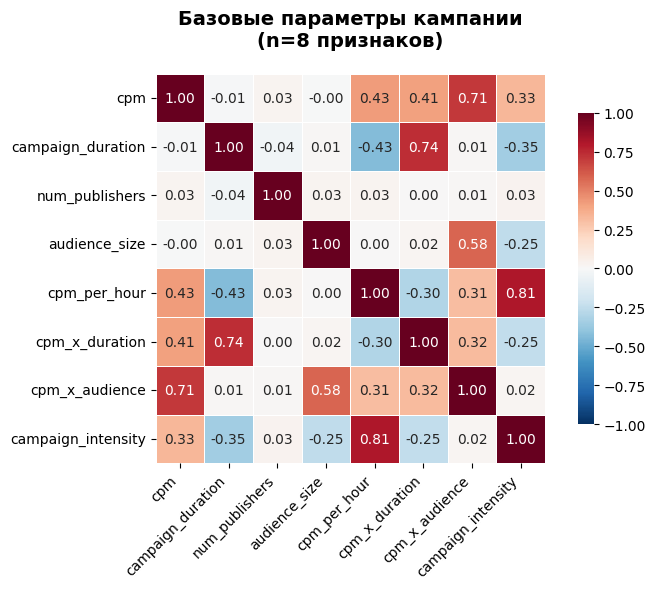

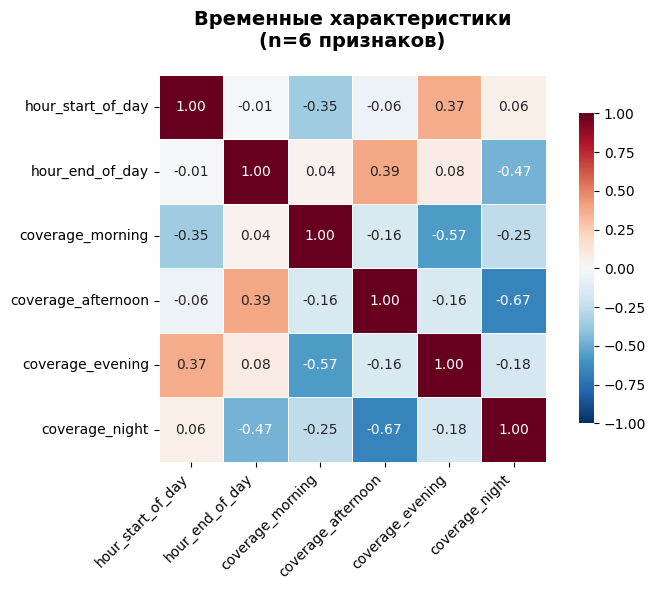

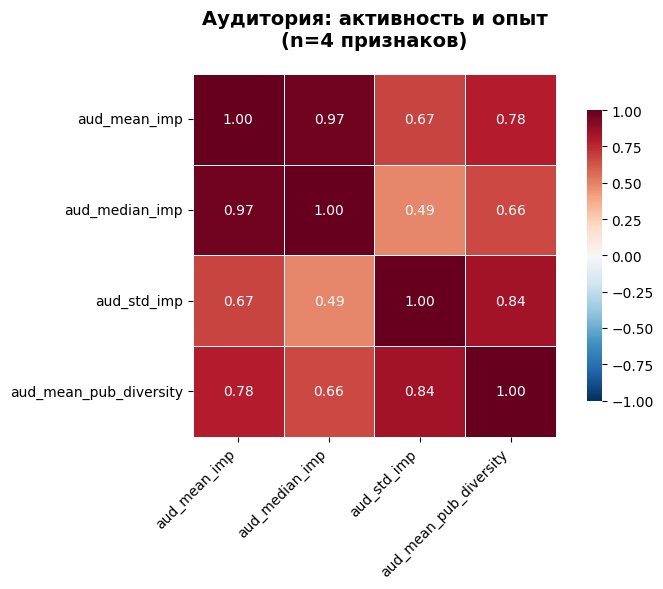

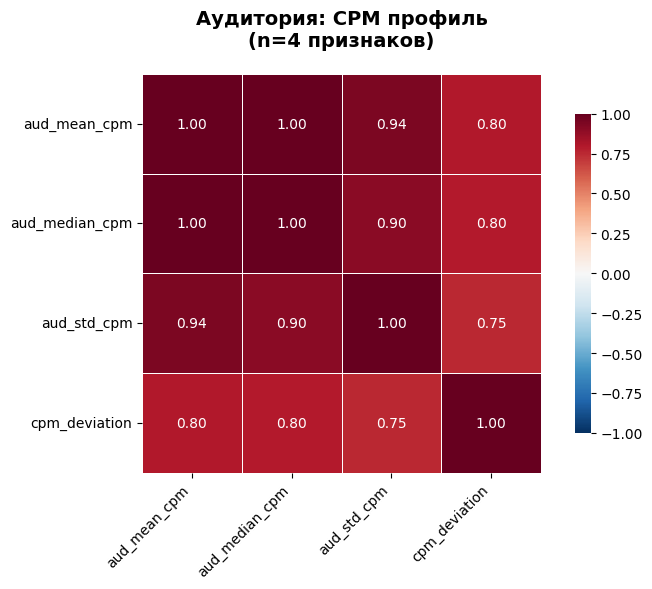

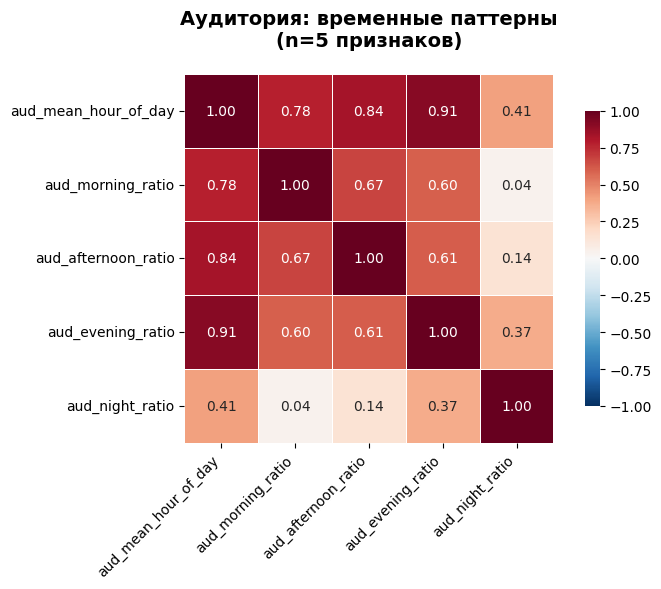

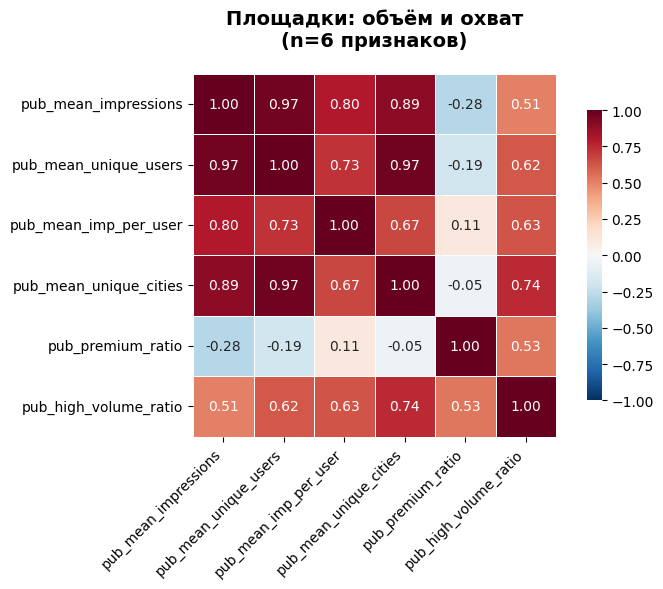

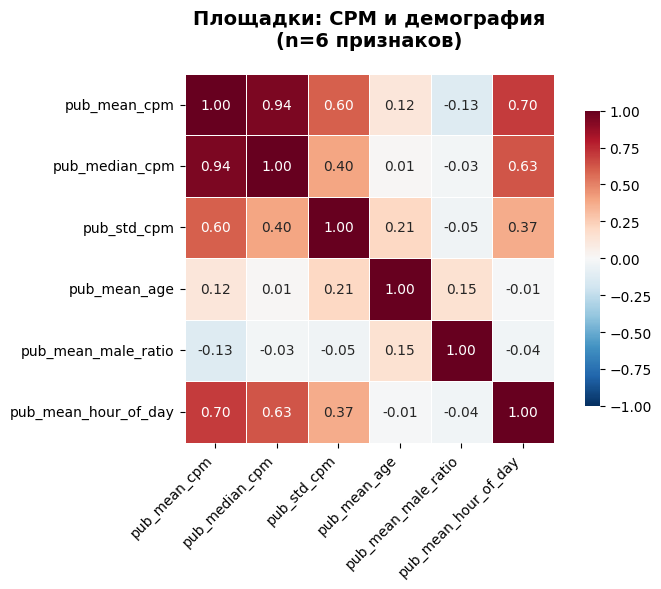

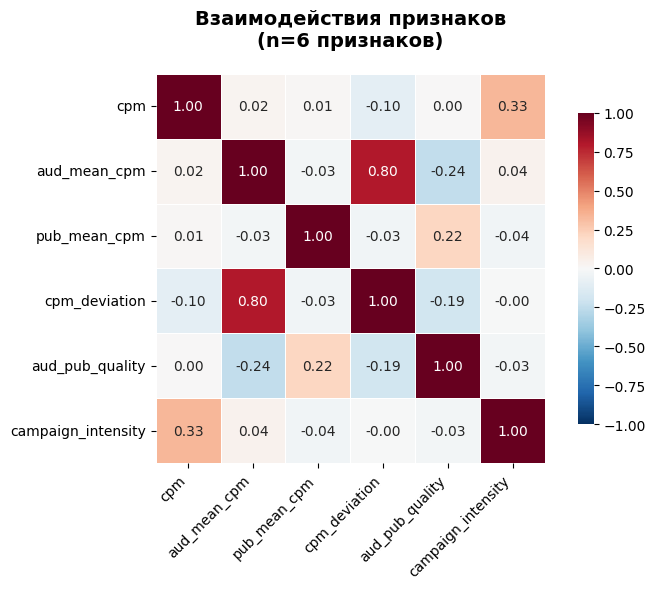

In [62]:
def plot_correlation_matrix(data, features, title, figsize=(8, 6)):
    existing_features = [f for f in features if f in data.columns]
    corr = data[existing_features].corr()

    plt.figure(figsize=figsize)

    sns.heatmap(
        corr,
        annot=True,
        fmt='.2f',
        cmap='RdBu_r',
        center=0,
        vmin=-1,
        vmax=1,
        square=True,
        linewidths=0.5,
        cbar_kws={'shrink': 0.8}
    )
    
    plt.title(f'{title}\n(n={len(existing_features)} признаков)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    print()

for group_name, features in feature_groups.items():
    plot_correlation_matrix(validate, features, group_name)

In [63]:
feature_groups = {
    'Базовые параметры кампании': [
        'cpm',
        'campaign_duration',
        'num_publishers',
        'audience_size',
        'cpm_per_hour',
        'cpm_x_duration',
        'cpm_x_audience',
        'campaign_intensity'
    ],

    'Временные характеристики': [
        'hour_start_of_day',
        'hour_end_of_day',
        'coverage_morning',
        'coverage_afternoon',
        'coverage_evening',
        'coverage_night'
    ],
    
    'Аудитория: активность и опыт': [
        'aud_mean_imp',
        'aud_std_imp'
    ],
    
    'Аудитория: CPM профиль': [
        'aud_std_cpm',
        'cpm_deviation'
    ],

    'Аудитория: временные паттерны': [
        'aud_mean_hour_of_day'
    ],
    
    'Площадки: объём и охват': [
        'pub_mean_impressions',
        'pub_mean_imp_per_user',
        'pub_mean_unique_cities',
        'pub_premium_ratio',
        'pub_high_volume_ratio'
    ],
    
    'Площадки: CPM и демография': [
        
        'pub_mean_cpm',
        'pub_std_cpm',
        'pub_mean_age',
        'pub_mean_male_ratio',
        'pub_mean_hour_of_day'
    ],

    'Взаимодействия признаков': [
        'cpm',
        'aud_mean_cpm',
        'pub_mean_cpm',
        'cpm_deviation',
        'aud_pub_quality',
        'campaign_intensity'
    ]
}

In [64]:
feature_columns = [
    'cpm',
    'campaign_duration',
    'num_publishers',
    'audience_size',
    'cpm_per_hour',
    'cpm_x_duration',
    'cpm_x_audience',
    'campaign_intensity'
]

X = validate[feature_columns].copy()
y = answers[['at_least_one', 'at_least_two', 'at_least_three']].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"Train: {X_train.shape[0]} строк")
print(f"{X_test.shape[0]} строк")


Train: 806 строк
202 строк


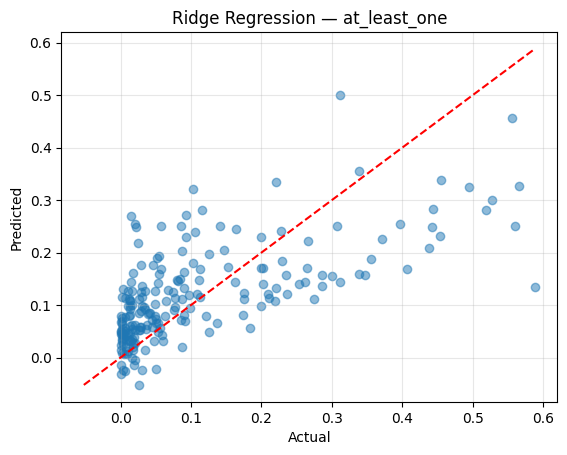

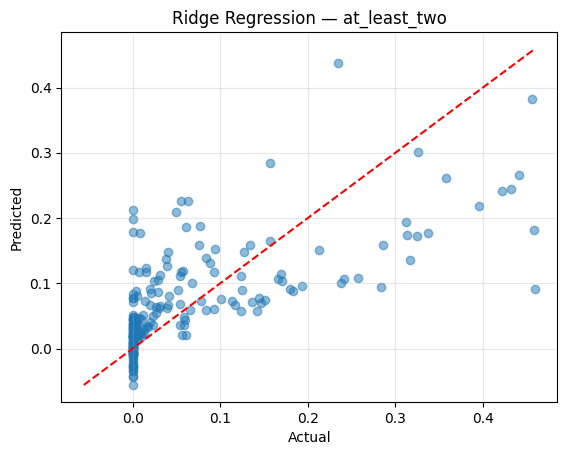

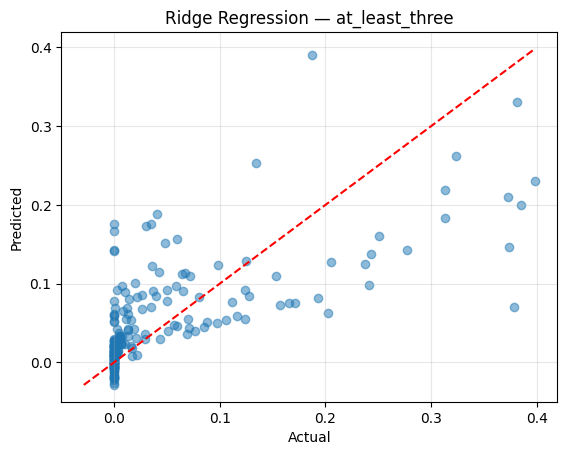

In [65]:
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

models = {}
predictions = {}

targets = ['at_least_one', 'at_least_two', 'at_least_three']

for target in targets:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=1.0))
    ])

    model.fit(X_train, y_train[target])
    models[target] = model

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    predictions[target] = {
        "train": y_train_pred,
        "test": y_test_pred
    }

    # Actual vs Predicted (TEST)
    plt.figure()
    plt.scatter(y_test[target], y_test_pred, alpha=0.5)
    min_val = min(y_test[target].min(), y_test_pred.min())
    max_val = max(y_test[target].max(), y_test_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], "r--")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Ridge Regression — {target}")
    plt.grid(alpha=0.3)
    plt.show()



In [66]:
models = {}
predictions = {}

targets = ['at_least_one', 'at_least_two', 'at_least_three']

for target in targets:
    model = LinearRegression()
    model.fit(X_train, y_train[target])
    models[target] = model

    # предсказания
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    predictions[target] = {
        'train': y_train_pred,
        'test': y_test_pred
    }

In [67]:
metrics = {}
tables = {}

for target in targets:
    y_train_true = y_train[target]
    y_test_true = y_test[target]

    y_train_pred = predictions[target]['train']
    y_test_pred = predictions[target]['test']

    metrics[target] = {
        'train_r2': r2_score(y_train_true, y_train_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train_true, y_train_pred)),
        'train_mae': mean_absolute_error(y_train_true, y_train_pred),
        'test_r2': r2_score(y_test_true, y_test_pred),
        'test_rmse': np.sqrt(mean_squared_error(y_test_true, y_test_pred)),
        'test_mae': mean_absolute_error(y_test_true, y_test_pred),
    }

    tables[target] = pd.DataFrame(
        {
            "train": [
                metrics[target]['train_r2'],
                metrics[target]['train_rmse'],
                metrics[target]['train_mae'],
            ],
            "test": [
                metrics[target]['test_r2'],
                metrics[target]['test_rmse'],
                metrics[target]['test_mae'],
            ],
        },
        index=["R2", "RMSE", "MAE"]
    )

    print(f"{target.upper()}")
    display(tables[target])


AT_LEAST_ONE


,train,test
R2,0.326875,0.434410
RMSE,0.121531,0.103315
MAE,0.082861,0.078234


AT_LEAST_TWO


,train,test
R2,0.340995,0.471031
RMSE,0.097561,0.078177
MAE,0.056229,0.054020


AT_LEAST_THREE


,train,test
R2,0.337897,0.489496
RMSE,0.082572,0.063085
MAE,0.042552,0.040405


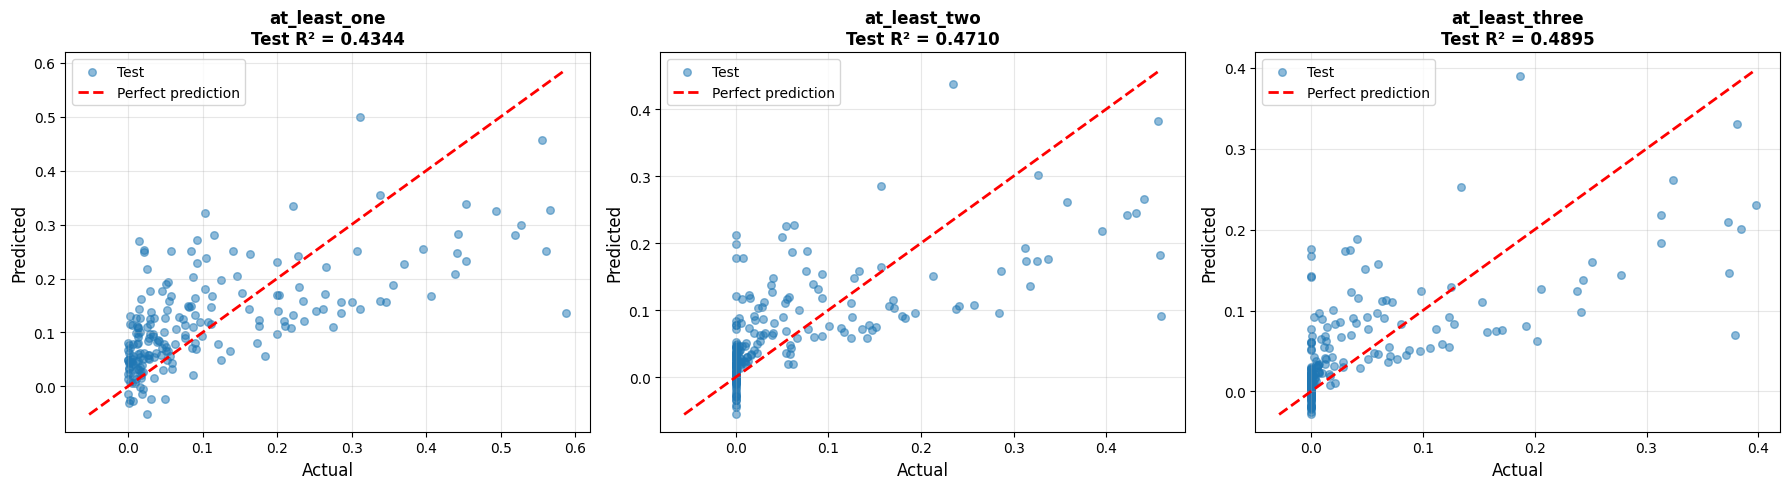

In [68]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

targets = ['at_least_one', 'at_least_two', 'at_least_three']

for idx, target in enumerate(targets):
    ax = axes[idx]

    ax.scatter(
        y_test[target],
        predictions[target]['test'],
        alpha=0.5,
        s=30,
        label='Test'
    )
    min_val = min(
        y_test[target].min(),
        predictions[target]['test'].min()
    )
    max_val = max(
        y_test[target].max(),
        predictions[target]['test'].max()
    )

    ax.plot(
        [min_val, max_val],
        [min_val, max_val],
        'r--',
        lw=2,
        label='Perfect prediction'
    )
    ax.set_xlabel('Actual', fontsize=12)
    ax.set_ylabel('Predicted', fontsize=12)
    ax.set_title(
        f'{target}\nTest R² = {metrics[target]["test_r2"]:.4f}',
        fontsize=12,
        fontweight='bold'
    )

    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [69]:
feature_columns_1 = {
        'cpm',
        'campaign_duration',
        'num_publishers',
        'audience_size',
        'cpm_per_hour',
        'cpm_x_duration',
        'cpm_x_audience',
        'campaign_intensity',
        'hour_start_of_day',
        'hour_end_of_day',
        'coverage_morning',
        'coverage_afternoon',
        'coverage_evening',
        'coverage_night',
        'aud_mean_imp',
        'aud_std_imp',
        'aud_std_cpm',
        'cpm_deviation',
        'aud_mean_hour_of_day',
        'pub_mean_impressions',
        'pub_mean_imp_per_user',
        'pub_mean_unique_cities',
        'pub_premium_ratio',
        'pub_high_volume_ratio',
        'pub_mean_cpm',
        'pub_std_cpm',
        'pub_mean_age',
        'pub_mean_male_ratio',
        'pub_mean_hour_of_day',
        'cpm',
        'aud_mean_cpm',
        'pub_mean_cpm',
        'cpm_deviation',
        'aud_pub_quality',
        'campaign_intensity'
}

feature_columns = list(feature_columns_1)

X = validate[feature_columns].copy()
y = answers[['at_least_one', 'at_least_two', 'at_least_three']].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"Train: {X_train.shape[0]} строк")
print(f"{X_test.shape[0]} строк")


Train: 806 строк
202 строк


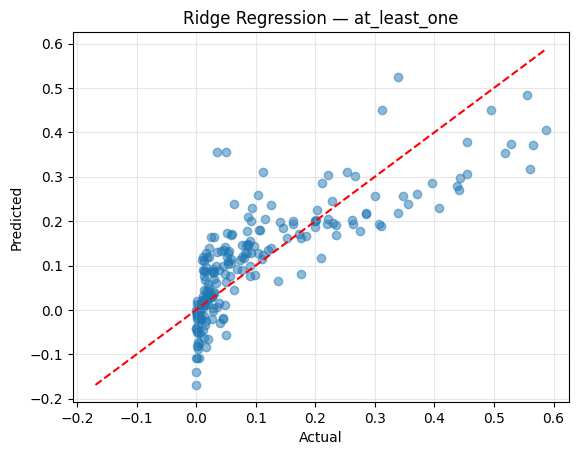

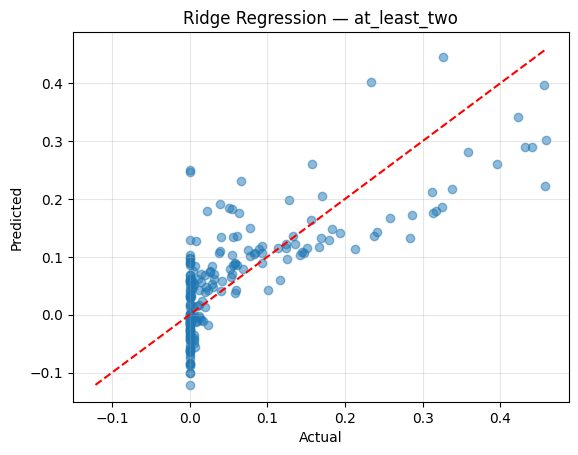

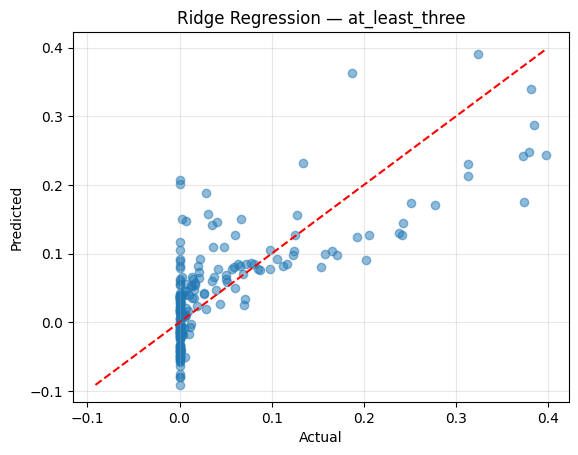

In [70]:
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

models = {}
predictions = {}

targets = ['at_least_one', 'at_least_two', 'at_least_three']

for target in targets:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=1.0))
    ])

    model.fit(X_train, y_train[target])
    models[target] = model

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    predictions[target] = {
        "train": y_train_pred,
        "test": y_test_pred
    }

    # Actual vs Predicted (TEST)
    plt.figure()
    plt.scatter(y_test[target], y_test_pred, alpha=0.5)
    min_val = min(y_test[target].min(), y_test_pred.min())
    max_val = max(y_test[target].max(), y_test_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], "r--")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Ridge Regression — {target}")
    plt.grid(alpha=0.3)
    plt.show()



In [71]:
models = {}
predictions = {}

targets = ['at_least_one', 'at_least_two', 'at_least_three']

for target in targets:
    model = LinearRegression()
    model.fit(X_train, y_train[target])
    models[target] = model

    # предсказания
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    predictions[target] = {
        'train': y_train_pred,
        'test': y_test_pred
    }

In [72]:
metrics = {}
tables = {}

for target in targets:
    y_train_true = y_train[target]
    y_test_true = y_test[target]

    y_train_pred = predictions[target]['train']
    y_test_pred = predictions[target]['test']

    metrics[target] = {
        'train_r2': r2_score(y_train_true, y_train_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train_true, y_train_pred)),
        'train_mae': mean_absolute_error(y_train_true, y_train_pred),
        'test_r2': r2_score(y_test_true, y_test_pred),
        'test_rmse': np.sqrt(mean_squared_error(y_test_true, y_test_pred)),
        'test_mae': mean_absolute_error(y_test_true, y_test_pred),
    }

    tables[target] = pd.DataFrame(
        {
            "train": [
                metrics[target]['train_r2'],
                metrics[target]['train_rmse'],
                metrics[target]['train_mae'],
            ],
            "test": [
                metrics[target]['test_r2'],
                metrics[target]['test_rmse'],
                metrics[target]['test_mae'],
            ],
        },
        index=["R2", "RMSE", "MAE"]
    )

    print(f"{target.upper()}")
    display(tables[target])


AT_LEAST_ONE


,train,test
R2,0.660310,0.622221
RMSE,0.086334,0.084437
MAE,0.064122,0.064648


AT_LEAST_TWO


,train,test
R2,0.577000,0.563143
RMSE,0.078163,0.071045
MAE,0.053822,0.053881


AT_LEAST_THREE


,train,test
R2,0.549874,0.549428
RMSE,0.068083,0.059266
MAE,0.044249,0.043838


In [49]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

metrics = {}
tables = {}
epsilon = 1e-10  # небольшое число, чтобы избежать деления на ноль

def log_metric(y_true, y_pred, eps=epsilon):
    return 100 * (np.exp(np.mean(np.abs(np.log((y_pred + eps) / (y_true + eps))))) - 1)

for target in targets:
    y_train_true = y_train[target]
    y_test_true = y_test[target]

    y_train_pred = predictions[target]['train']
    y_test_pred = predictions[target]['test']

    metrics[target] = {
        'train_r2': r2_score(y_train_true, y_train_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train_true, y_train_pred)),
        'train_mae': mean_absolute_error(y_train_true, y_train_pred),
        'train_log_metric': log_metric(y_train_true, y_train_pred),  # новая метрика
        'test_r2': r2_score(y_test_true, y_test_pred),
        'test_rmse': np.sqrt(mean_squared_error(y_test_true, y_test_pred)),
        'test_mae': mean_absolute_error(y_test_true, y_test_pred),
        'test_log_metric': log_metric(y_test_true, y_test_pred),    # новая метрика
    }

    tables[target] = pd.DataFrame(
        {
            "train": [
                metrics[target]['train_r2'],
                metrics[target]['train_rmse'],
                metrics[target]['train_mae'],
                metrics[target]['train_log_metric'],
            ],
            "test": [
                metrics[target]['test_r2'],
                metrics[target]['test_rmse'],
                metrics[target]['test_mae'],
                metrics[target]['test_log_metric'],
            ],
        },
        index=["R2", "RMSE", "MAE", "LogMetric"]
    )

    print(f"{target.upper()}")
    display(tables[target])


AT_LEAST_ONE


/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,train,test
R2,0.660310,0.622221
RMSE,0.086334,0.084437
MAE,0.064122,0.064648
LogMetric,136.198998,100.651308


AT_LEAST_TWO


/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,train,test
R2,0.577000,0.563143
RMSE,0.078163,0.071045
MAE,0.053822,0.053881
LogMetric,11770.772604,13785.046878


AT_LEAST_THREE


/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,train,test
R2,0.549874,0.549428
RMSE,0.068083,0.059266
MAE,0.044249,0.043838
LogMetric,97489.030190,71112.590203


In [76]:
def smlar(y_true, y_pred, epsilon=1e-10):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    # Убираем NaN
    mask = (~np.isnan(y_true)) & (~np.isnan(y_pred))
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    # Клиппинг (КРИТИЧЕСКИ ВАЖНО)
    y_true = np.clip(y_true, epsilon, None)
    y_pred = np.clip(y_pred, epsilon, None)

    log_ratio = np.log(y_pred / y_true)
    return 100 * (np.exp(np.mean(np.abs(log_ratio))) - 1)


In [77]:
metrics = {}
tables = {}

for target in targets:
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # клиппинг ТОЛЬКО для SMLAR
    y_train_pred_clip = np.clip(y_train_pred, 0, None)
    y_test_pred_clip = np.clip(y_test_pred, 0, None)

    metrics[target] = {
        'train_r2': r2_score(y_train[target], y_train_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train[target], y_train_pred)),
        'train_mae': mean_absolute_error(y_train[target], y_train_pred),
        'train_smlar': smlar(y_train[target], y_train_pred_clip),

        'test_r2': r2_score(y_test[target], y_test_pred),
        'test_rmse': np.sqrt(mean_squared_error(y_test[target], y_test_pred)),
        'test_mae': mean_absolute_error(y_test[target], y_test_pred),
        'test_smlar': smlar(y_test[target], y_test_pred_clip),
    }


    tables[target] = pd.DataFrame(
        {
            "train": [
                metrics[target]['train_r2'],
                metrics[target]['train_rmse'],
                metrics[target]['train_mae'],
                metrics[target]['train_smlar'],
            ],
            "test": [
                metrics[target]['test_r2'],
                metrics[target]['test_rmse'],
                metrics[target]['test_mae'],
                metrics[target]['test_smlar'],
            ],
        },
        index=["R2", "RMSE", "MAE", "SMLAR (%)"]
    )

    print(f"{target.upper()}")
    display(tables[target])


AT_LEAST_ONE


,train,test
R2,0.307644,0.353369
RMSE,0.123255,0.110469
MAE,0.081249,0.076138
SMLAR (%),15229.849887,36635.120961


AT_LEAST_TWO


,train,test
R2,0.527236,0.553117
RMSE,0.082633,0.071855
MAE,0.050997,0.050651
SMLAR (%),10485.557895,10941.704637


AT_LEAST_THREE


,train,test
R2,0.549874,0.549428
RMSE,0.068083,0.059266
MAE,0.044249,0.043838
SMLAR (%),27537.737870,25852.896916


In [80]:
validate_enriched_cat = validate.copy()

validate_enriched_cat['cpm_category'] = pd.cut(
    validate_enriched_cat['cpm'],
    bins=[0, 50, 100, 200, 500, np.inf],
    labels=['very_low', 'low', 'medium', 'high', 'premium']
).astype(str)

validate_enriched_cat['audience_category'] = pd.qcut(
    validate_enriched_cat['audience_size'],
    q=4,
    labels=['small', 'medium', 'large', 'very_large'],
    duplicates='drop'
).astype(str)

validate_enriched_cat['duration_category'] = pd.cut(
    validate_enriched_cat['campaign_duration'],
    bins=[0, 24, 72, 168, np.inf],
    labels=['short', 'medium', 'long', 'very_long']
).astype(str)

def get_dominant_time(row):
    times = {
        'morning': row['coverage_morning'],
        'afternoon': row['coverage_afternoon'],
        'evening': row['coverage_evening'],
        'night': row['coverage_night']
    }
    return max(times, key=times.get)

validate_enriched_cat['dominant_time'] = validate_enriched_cat.apply(
    get_dominant_time, axis=1
)

validate_enriched_cat['publishers_category'] = validate_enriched_cat['num_publishers'].apply(
    lambda x: 'single' if x == 1 else 'dual' if x == 2 else 'multiple'
)

validate_enriched_cat['audience_experience'] = pd.qcut(
    validate_enriched_cat['aud_mean_imp'],
    q=3,
    labels=['novice', 'regular', 'heavy'],
    duplicates='drop'
).astype(str)

validate_enriched_cat['publisher_type'] = validate_enriched_cat['pub_premium_ratio'].apply(
    lambda x: 'premium' if x > 0.5 else 'mixed' if x > 0 else 'mass'
)


In [81]:
numeric_features = list(dict.fromkeys([
    'cpm',
    'campaign_duration',
    'num_publishers',
    'audience_size',
    'cpm_per_hour',
    'cpm_x_duration',
    'cpm_x_audience',
    'campaign_intensity',
    'hour_start_of_day',
    'hour_end_of_day',
    'coverage_morning',
    'coverage_afternoon',
    'coverage_evening',
    'coverage_night',
    'aud_mean_imp',
    'aud_std_imp',
    'aud_std_cpm',
    'cpm_deviation',
    'aud_mean_hour_of_day',
    'pub_mean_impressions',
    'pub_mean_imp_per_user',
    'pub_mean_unique_cities',
    'pub_premium_ratio',
    'pub_high_volume_ratio',
    'pub_mean_cpm',
    'pub_std_cpm',
    'pub_mean_age',
    'pub_mean_male_ratio',
    'pub_mean_hour_of_day',
    'aud_mean_cpm',
    'aud_pub_quality'
]))

categorical_features = [
    'cpm_category',
    'audience_category',
    'duration_category',
    'dominant_time',
    'publishers_category',
    'audience_experience',
    'publisher_type'
]

all_features = numeric_features + categorical_features
cat_features_idx = [all_features.index(f) for f in categorical_features]


In [82]:
targets = ['at_least_one', 'at_least_two', 'at_least_three']

models = {}
predictions = {}
metrics = {}

for target in targets:
    train_pool = Pool(
        X_train, y_train[target],
        cat_features=cat_features_idx
    )
    val_pool = Pool(
        X_val, y_val[target],
        cat_features=cat_features_idx
    )
    test_pool = Pool(
        X_test, y_test[target],
        cat_features=cat_features_idx
    )

    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=42,
        early_stopping_rounds=50,
        verbose=100
    )

    model.fit(train_pool, eval_set=val_pool)

    models[target] = model

    y_train_pred = model.predict_proba(train_pool)[:, 1]
    y_test_pred = model.predict_proba(test_pool)[:, 1]

    predictions[target] = {
        'train': y_train_pred,
        'test': y_test_pred
    }

    metrics[target] = {
        'train_r2': r2_score(y_train[target], y_train_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train[target], y_train_pred)),
        'train_mae': mean_absolute_error(y_train[target], y_train_pred),
        'test_r2': r2_score(y_test[target], y_test_pred),
        'test_rmse': np.sqrt(mean_squared_error(y_test[target], y_test_pred)),
        'test_mae': mean_absolute_error(y_test[target], y_test_pred),
    }

    print(
        target,
        'min y:', y_train[target].min(),
        'min pred:', y_train_pred.min()
    )


CatBoostError: Invalid cat_features[0] = 31 value: index must be < 31.

In [ ]:
targets = ['at_least_one', 'at_least_two', 'at_least_three']
models = {}
predictions = {}
metrics = {}

cat_features_idx = [all_features.index(f) for f in categorical_features]

for target in targets:
    train_pool = Pool(X_train, y_train[target], cat_features=cat_features_idx)
    test_pool = Pool(X_test, y_test[target], cat_features=cat_features_idx)
    
    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='RMSE',
        eval_metric='RMSE',
        random_seed=42,
        verbose=False,
        early_stopping_rounds=50,
        use_best_model=True
    )
    model.fit(train_pool, eval_set=test_pool, verbose=100)
    
    models[target] = model
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    predictions[target] = {'train': y_train_pred, 'test': y_test_pred}
    
    metrics[target] = {
        'train_r2': r2_score(y_train[target], y_train_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train[target], y_train_pred)),
        'train_mae': mean_absolute_error(y_train[target], y_train_pred),
        'train_smlar': smlar(y_train[target], y_train_pred),
        'test_r2': r2_score(y_test[target], y_test_pred),
        'test_rmse': np.sqrt(mean_squared_error(y_test[target], y_test_pred)),
        'test_mae': mean_absolute_error(y_test[target], y_test_pred),
        'test_smlar': smlar(y_test[target], y_test_pred),
    }
print(np.min(y_train[target]), np.min(predictions[target]['train']))


0:	learn: 0.1455086	test: 0.1353397	best: 0.1353397 (0)	total: 16.9ms	remaining: 16.9s
100:	learn: 0.0758366	test: 0.0834511	best: 0.0834511 (100)	total: 454ms	remaining: 4.04s
200:	learn: 0.0636795	test: 0.0817893	best: 0.0815538 (189)	total: 713ms	remaining: 2.83s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.08155379577
bestIteration = 189

Shrink model to first 190 iterations.
0:	learn: 0.1177311	test: 0.1054841	best: 0.1054841 (0)	total: 2.06ms	remaining: 2.06s


/var/folders/jt/9cw9vcn955984km8tfldxk7r0000gn/T/ipykernel_13726/3524448147.py:19: RuntimeWarning: invalid value encountered in log
  log_ratio = np.log(y_pred_smooth / y_true_smooth)
/var/folders/jt/9cw9vcn955984km8tfldxk7r0000gn/T/ipykernel_13726/3524448147.py:19: RuntimeWarning: invalid value encountered in log
  log_ratio = np.log(y_pred_smooth / y_true_smooth)


100:	learn: 0.0554097	test: 0.0629928	best: 0.0629928 (100)	total: 280ms	remaining: 2.49s
200:	learn: 0.0423101	test: 0.0598263	best: 0.0598263 (200)	total: 740ms	remaining: 2.94s
300:	learn: 0.0341131	test: 0.0586725	best: 0.0586038 (295)	total: 1.03s	remaining: 2.39s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.05860375552
bestIteration = 295

Shrink model to first 296 iterations.


/var/folders/jt/9cw9vcn955984km8tfldxk7r0000gn/T/ipykernel_13726/3524448147.py:19: RuntimeWarning: invalid value encountered in log
  log_ratio = np.log(y_pred_smooth / y_true_smooth)
/var/folders/jt/9cw9vcn955984km8tfldxk7r0000gn/T/ipykernel_13726/3524448147.py:19: RuntimeWarning: invalid value encountered in log
  log_ratio = np.log(y_pred_smooth / y_true_smooth)


0:	learn: 0.0993846	test: 0.0866061	best: 0.0866061 (0)	total: 3.27ms	remaining: 3.26s
100:	learn: 0.0436192	test: 0.0522574	best: 0.0522574 (100)	total: 388ms	remaining: 3.45s
200:	learn: 0.0312095	test: 0.0494688	best: 0.0494029 (195)	total: 654ms	remaining: 2.6s
300:	learn: 0.0250980	test: 0.0493069	best: 0.0491443 (277)	total: 972ms	remaining: 2.26s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.04914425403
bestIteration = 277

Shrink model to first 278 iterations.
0.0 -0.007929947470724688


/var/folders/jt/9cw9vcn955984km8tfldxk7r0000gn/T/ipykernel_13726/3524448147.py:19: RuntimeWarning: invalid value encountered in log
  log_ratio = np.log(y_pred_smooth / y_true_smooth)
/var/folders/jt/9cw9vcn955984km8tfldxk7r0000gn/T/ipykernel_13726/3524448147.py:19: RuntimeWarning: invalid value encountered in log
  log_ratio = np.log(y_pred_smooth / y_true_smooth)


In [ ]:

# ============================================================================
# 6. ТАБЛИЦЫ МЕТРИК
# ============================================================================

tables = {}

for target in targets:
    tables[target] = pd.DataFrame(
        {
            "Train": [
                f"{metrics[target]['train_r2']:.4f}",
                f"{metrics[target]['train_rmse']:.4f}",
                f"{metrics[target]['train_mae']:.4f}",
                f"{metrics[target]['train_smlar']:.2f}%",
            ],
            "Test": [
                f"{metrics[target]['test_r2']:.4f}",
                f"{metrics[target]['test_rmse']:.4f}",
                f"{metrics[target]['test_mae']:.4f}",
                f"{metrics[target]['test_smlar']:.2f}%",
            ],
        },
        index=["R²", "RMSE", "MAE", "SMLAR"]
    )
    print(f"\n🎯 {target.upper()}")
    display(tables[target])
